# Titanic: Machine Learning from Disaster [79.9%] 

### RandomForestClassifier

In [41]:
from IPython.display import Image
Image(url= "https://cms.qz.com/wp-content/uploads/2014/01/titanic-paramout-pics-web.jpg?quality=75&strip=all&w=1100&h=619")

In [142]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
def side_by_side(*objs, **kwds):
    from pandas.io.formats.printing import adjoin
    space = kwds.get('space', 4)
    reprs = [repr(obj).split('\n') for obj in objs]
    print (adjoin(space, *reprs))
    print()
    return

## 1. Data loading and cleaning 

In [109]:
titanic_data = pd.read_csv("train.csv", encoding = 'UTF-8') 
titanic_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [119]:
side_by_side(titanic_data.isnull().sum(), titanic_data.count())

PassengerId      0    PassengerId    891
Survived         0    Survived       891
Pclass           0    Pclass         891
Name             0    Name           891
Sex              0    Sex            891
Age            177    Age            714
SibSp            0    SibSp          891
Parch            0    Parch          891
Ticket           0    Ticket         891
Fare             0    Fare           891
Cabin          687    Cabin          204
Embarked         0    Embarked       891
Title            0    Title          891
dtype: int64          dtype: int64      



In [45]:
titanic_data.drop(["Cabin"], axis=1, inplace = True) 

## 2. Feature Selection 

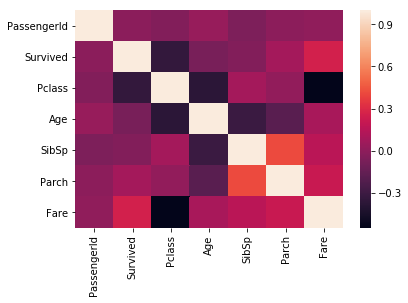

In [111]:
corr = titanic_data.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [112]:
titanic_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [113]:
titanic_data["Embarked"].fillna('S', inplace=True)

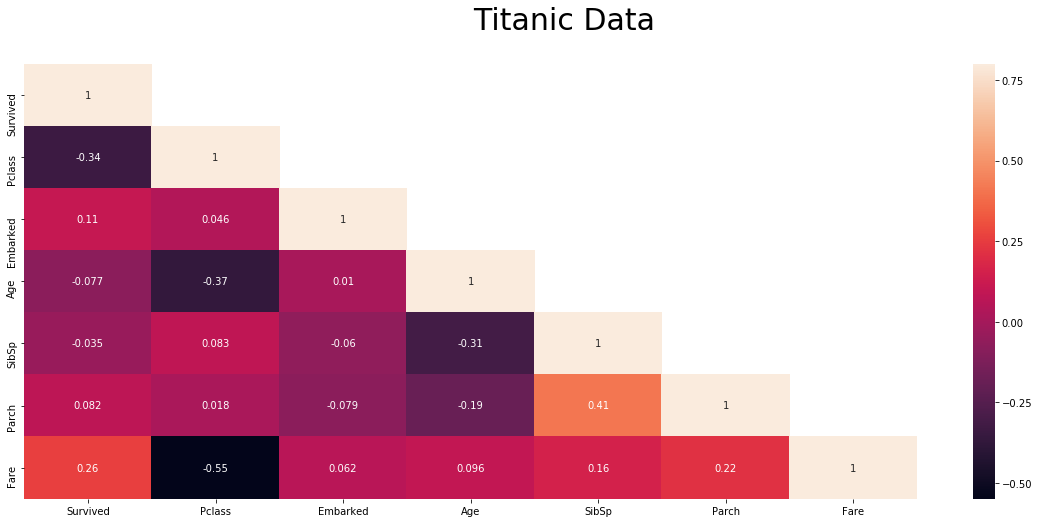

In [120]:
fig,ax = plt.subplots(figsize=(20,8))
fig.suptitle("Titanic Data", fontsize=30)
corrcoef = titanic_data[['Survived', 'Pclass', 'Sex', 'Embarked', 
                         'Age', 'SibSp', 'Parch', 'Fare']].corr()
mask = np.array(corrcoef)
mask[np.tril_indices_from(mask)] = False
sns.heatmap(corrcoef, mask=mask, vmax=.8, annot=True, ax=ax)
plt.show();

### 2.1 Name 

In [116]:
titanic_data['Title'] = titanic_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [117]:
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, 
                 "Master": 3, "Dr": 3, "Rev": 3, "Col": 3, "Major": 3, "Mlle": 3,"Countess": 3,
                 "Ms": 3, "Lady": 3, "Jonkheer": 3, "Don": 3, "Dona" : 3, "Mme": 3,"Capt": 3,"Sir": 3 }

titanic_data['Title'] = titanic_data['Title'].map(title_mapping)

### 2.2 Emarked 

In [118]:
#titanic_data["Embarked"].fillna('S', inplace=True)

embarked_mapping = {"S": 0, "C": 1, "Q": 2}
titanic_data['Embarked'] = titanic_data['Embarked'].map(embarked_mapping)

### 2.3 Age [rejected feature]

In [121]:
titanic_data.loc[ titanic_data['Age'] <= 16, 'Age'] = 0,
titanic_data.loc[(titanic_data['Age'] > 16) & (titanic_data['Age'] <= 26), 'Age'] = 1,
titanic_data.loc[(titanic_data['Age'] > 26) & (titanic_data['Age'] <= 36), 'Age'] = 2,
titanic_data.loc[(titanic_data['Age'] > 36) & (titanic_data['Age'] <= 62), 'Age'] = 3,
titanic_data.loc[ titanic_data['Age'] > 62, 'Age'] = 4

In [122]:
titanic_data["Age"].fillna(2, inplace=True)

In [123]:
side_by_side(titanic_data.isnull().sum(), titanic_data.count())

PassengerId      0    PassengerId    891
Survived         0    Survived       891
Pclass           0    Pclass         891
Name             0    Name           891
Sex              0    Sex            891
Age              0    Age            891
SibSp            0    SibSp          891
Parch            0    Parch          891
Ticket           0    Ticket         891
Fare             0    Fare           891
Cabin          687    Cabin          204
Embarked         0    Embarked       891
Title            0    Title          891
dtype: int64          dtype: int64      



### Preparing data 

In [124]:
titanic_data["Gender"] = 0

for i in range(0, len(titanic_data)): 
    if titanic_data["Sex"].iloc[i] == 'female':
        titanic_data["Gender"].iloc[i] = 1         

C:\Users\Saitama\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [125]:
titanic_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Gender
0,1,0,3,"Braund, Mr. Owen Harris",male,1.0,1,0,A/5 21171,7.2500,NaN,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,3.0,1,0,PC 17599,71.2833,C85,1,2,1
2,3,1,3,"Heikkinen, Miss. Laina",female,1.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,2.0,1,0,113803,53.1000,C123,0,2,1
4,5,0,3,"Allen, Mr. William Henry",male,2.0,0,0,373450,8.0500,NaN,0,0,0
5,6,0,3,"Moran, Mr. James",male,2.0,0,0,330877,8.4583,NaN,2,0,0
6,7,0,1,"McCarthy, Mr. Timothy J",male,3.0,0,0,17463,51.8625,E46,0,0,0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,0.0,3,1,349909,21.0750,NaN,0,3,0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,2.0,0,2,347742,11.1333,NaN,0,2,1
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,0.0,1,0,237736,30.0708,NaN,1,2,1


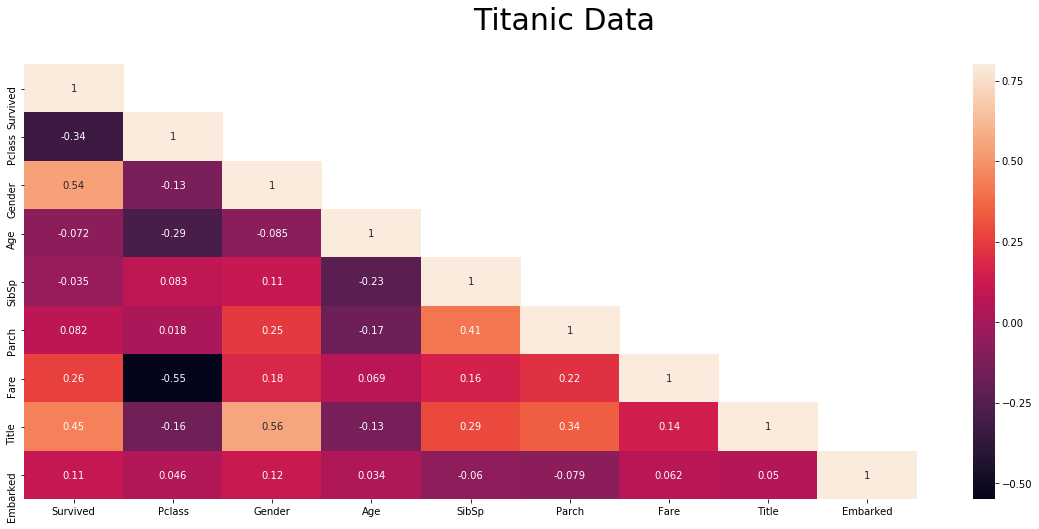

In [126]:
fig,ax = plt.subplots(figsize=(20,8))
fig.suptitle("Titanic Data", fontsize=30)
corrcoef = titanic_data[['Survived', 'Pclass', 'Gender', 
                         'Age', 'SibSp', 'Parch', 'Fare', 'Title', 'Embarked']].corr()
mask = np.array(corrcoef)
mask[np.tril_indices_from(mask)] = False
sns.heatmap(corrcoef, mask=mask, vmax=.8, annot=True, ax=ax)
plt.show();

### Exploring data 

In [127]:
women = titanic_data.loc[titanic_data.Gender == 1]["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

% of women who survived: 0.7420382165605095


In [128]:
men = titanic_data.loc[titanic_data.Gender == 0]["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


In [129]:
def bar_chart(train_data, feature): 
    survived = train_data[train_data['Survived']==1][feature].value_counts()
    dead = train_data[train_data['Survived']==0][feature].value_counts()
    df = pd.DataFrame([survived, dead])
    df.index = ['Survived', 'Dead'] 
    df.plot(kind='bar', stacked=True, figsize=(10, 5)) 

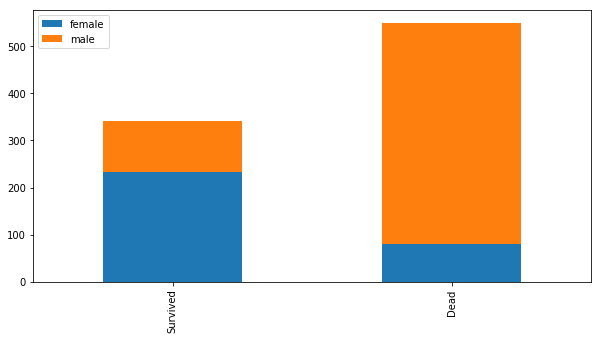

In [130]:
bar_chart(titanic_data, 'Sex')

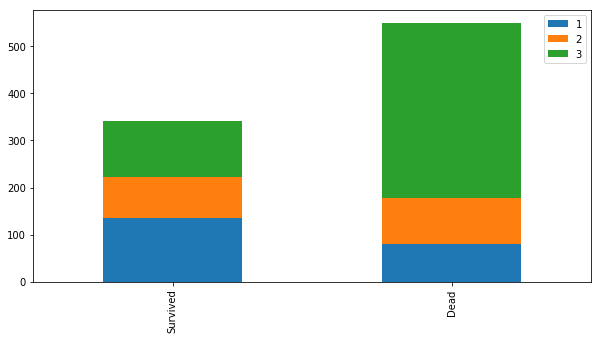

In [131]:
bar_chart(titanic_data, 'Pclass')

## 3.Train 

In [143]:
Features = ["Gender", "Parch", "Fare", "Pclass", "SibSp", "Title", "Embarked"]

Y = titanic_data["Survived"]
X = pd.get_dummies(titanic_data[Features])

model = LogisticRegression()
#model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
#model = SVC() 
#model = KNeighborsClassifier(n_neighbors = 13) 
model.fit(X, Y)
 

C:\Users\Saitama\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

## 4. Submit to Kaggle

In [147]:
Features = ["Gender", "Parch", "Fare", "Pclass", "SibSp", "Title", "Embarked"]
titanic_test_data = pd.read_csv("test.csv", encoding = 'UTF-8')  

# Name 
titanic_test_data['Title'] = titanic_test_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, 
                 "Master": 3, "Dr": 3, "Rev": 3, "Col": 3, "Major": 3, "Mlle": 3,"Countess": 3,
                 "Ms": 3, "Lady": 3, "Jonkheer": 3, "Don": 3, "Dona" : 3, "Mme": 3,"Capt": 3,"Sir": 3 }

titanic_test_data['Title'] = titanic_test_data['Title'].map(title_mapping)

# Embarked
titanic_test_data["Embarked"].fillna('S', inplace=True)

embarked_mapping = {"S": 0, "C": 1, "Q": 2}
titanic_test_data['Embarked'] = titanic_test_data['Embarked'].map(embarked_mapping)

# Gender 
titanic_test_data["Gender"] = 0

for i in range(0, len(titanic_test_data)): 
    if titanic_test_data["Sex"].iloc[i] == 'female':
        titanic_test_data["Gender"].iloc[i] = 1  


C:\Users\Saitama\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [148]:
titanic_test_data.fillna(0, inplace = True)

In [149]:
side_by_side(titanic_test_data.isnull().sum(), titanic_test_data.count())

PassengerId    0    PassengerId    418
Pclass         0    Pclass         418
Name           0    Name           418
Sex            0    Sex            418
Age            0    Age            418
SibSp          0    SibSp          418
Parch          0    Parch          418
Ticket         0    Ticket         418
Fare           0    Fare           418
Cabin          0    Cabin          418
Embarked       0    Embarked       418
Title          0    Title          418
Gender         0    Gender         418
dtype: int64        dtype: int64      



In [150]:
X_test = pd.get_dummies(titanic_test_data[Features]) 
predictions = model.predict(X_test) 

output = pd.DataFrame({'PassengerId': titanic_test_data.PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


## I got 79.9% score from Kaggle 